# Pipeline Template

## Introduction
This notebook is a part of the project to compare the performance of different pipelines for EEG elbow movement classification. The goal of these notebooks is to establish a standard pipeline for EEG elbow movement classification. 

This notebook explores the performance of the pipeline with just a standart scaler preprocessing. The pipeline is composed of 3 main steps:
1. Feature extraction: Standard scaler
2. Classification: Logistic regression, Linear discriminant analysis, Support vector machine, Random forest
3. Evaluation: Balanced accuracy

## Understanding the pipeline

A simple standard scaler is used to normalize the data. The data is then passed to the classification step. The classification step uses 4 different classifiers: Logistic regression, Linear discriminant analysis, Support vector machine, Random forest. The performance of the classifiers is evaluated using balanced accuracy.



## Methodology

In this notebook we aim to establish the performance of the rieman pipeline. Here are the steps we will follow:

1. Preprocessing:
    - Loading the data from each .npy file using Dataloader built for this project.
    - Using only the session which record the movement of the arm oposite to stroke side. (REQUIREMENT)
    - Using only the electrodes from the stroke side. (REQUIREMENT)
    - Labeling the data using the acceleration (done in the dataloader, see [labelling_data.ipynb](./../exploration_data/labelling_data.ipynb) for the exact process)
    - Filtering the data between 1 and 40 Hz.
    - Getting the train and test data by epoching around the movement onset. 1=extension 2=flexion 0=rest(or no onset to be precise) To get data labelled 0 we took epoch from 4s to 1s before movement onset.
    - Relabelling extension and flexion as 1 and no onset as 0.

2. Feature extraction:
    - **Standard scaler**
    
3. Classification: (compared differents classifiers)
    -  Logistic regression
    -  Linear discriminant analysis
    -  Support vector machine
    -  Random forest
    -  AdaBoost
    -  MLP
    
4. Evaluation:
    1. Evaluation on epoched data. Using balanced accuracy to evaluate the performance of the pipeline using 3 differents testers:
        -  Tester 1: Seen session / seen subject (but not the same data)
        -  Tester 2: Unseen session / seen subject (but not the same data)
        -  Tester 3: Unseen session / unseen subject
    2. Evaluation on continuous data : estimating the performance by visual feedback with density of prediction.

In [1]:
from ml_eeg_tools.preprocessing import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import mne
import os

## Hyperparameters

In [2]:
NUMBER_OF_SESSIONS = 1

# Fréquence de filtrage
FMIN = 1
FMAX = 40

# Bornes époques
EPOCHS_TMIN = -1
EPOCHS_LENGTH = 3
EPOCHS_TMAX = EPOCHS_TMIN + EPOCHS_LENGTH

# temps depuis le mouvement pour époquer autours d'une plage sans mouvement
EPOCHS_EMPTY_FROM_MVT_TMINS = -4

BINARY_CLASSIFICATION = True

RANDOM_STATE = 42
N_SPLIT = 4

FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

## Preprocessing

In [11]:
from ml_eeg_tools.preprocessing.data_preparation import prepare_data_train

settings_prepare_data = {
        "FMIN": FMIN,
        "FMAX": FMAX,
        "EPOCHS_TMIN": EPOCHS_TMIN,
        "EPOCHS_EMPTY_FROM_MVT_TMIN": EPOCHS_EMPTY_FROM_MVT_TMINS,
        "EPOCHS_TMAX": EPOCHS_TMAX,
        "BINARY_CLASSIFICATION": True,
        "RANDOM_STATE": RANDOM_STATE,
    }

data_patients, labels_patients, _, _ = prepare_data_train(
            FILE_PATH_LIST[: NUMBER_OF_SESSIONS], settings_prepare_data
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:08<00:00,  8.21s/it]


In [12]:
data_patients[0][0].shape

(38, 37, 3073)

## Pipeline

In [3]:
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

import pandas as pd
from joblib import dump, load
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import welch

### The pipeline definition

In [4]:
import numpy as np
import mne

class FlattenTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)

preproc_steps = [
    ('flatten', FlattenTransformer),
    ('ss', StandardScaler)
]


In [5]:
pipeline_steps = [(name, step()) for (name, step) in preproc_steps] + [('clf', RandomForestClassifier())]
    
pipeline = Pipeline(pipeline_steps)

### Fit

In [12]:
X_train = []
y_train = []
for i in range(len(data_patients)):
    for j in range(len(data_patients[i])):
        X_train.append(data_patients[i][j])
        y_train.append(labels_patients[i][j])

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(X_train.shape, y_train.shape)

pipeline.fit(X_train, y_train)

(350, 37, 3073) (350,)


Pipeline(steps=[('flatten', FlattenTransformer()), ('ss', StandardScaler()),
                ('clf', RandomForestClassifier())])

### Tests A, B, C, X

In [13]:
from ml_eeg_tools.test_model.test_epoch import (
    train_test_A,
    train_test_B,
    train_test_C,
    train_test_X,
)

scores = []
for score_fn in [train_test_A, train_test_B, train_test_C, train_test_X]:
    score = score_fn(
        data_patients,
        labels_patients,
        pipeline,
        RANDOM_STATE=RANDOM_STATE,
        N_SPLIT=N_SPLIT,
        verbose=False,
    )
    print(f'{score_fn.__name__}: {score}')
    scores.append(score)
    
df = pd.DataFrame(
    {
        "Score A": [scores[0]],
        "Score B": [scores[1]],
        "Score C": [scores[2]],
        "Score X": [scores[3]],
    }
) 


train_test_A: 0.6161390593402606
train_test_B: 0.625
train_test_C: 0.6115288220551378
train_test_X: 0.6032529064421501


In [14]:
steps_str_list = [step[1].__class__.__name__ for step in pipeline.steps]
df['mean_score_ABC'] = np.mean(scores[:3])
for i, step in enumerate(steps_str_list):
    df[f'step {i+1}'] = step

In [15]:
df

,Score A,Score B,Score C,Score X,mean_score_ABC,step 1,step 2,step 3
0,0.616139,0.625,0.611529,0.603253,0.617556,FlattenTransformer,StandardScaler,RandomForestClassifier


## Many classifiers

In [ ]:
pipelines = []

for model in [RandomForestClassifier, SVC, LogisticRegression, LinearDiscriminantAnalysis, AdaBoostClassifier, MLPClassifier]:
    pipelines_steps = [(name, step()) for (name, step) in preproc_steps] + [('clf', model())]
    pipelines.append(Pipeline(pipelines_steps))
    
scores_pipeline = []
for pipeline in pipelines:
    scores_mclf = []
    for score_fn in [train_test_A, train_test_B, train_test_C, train_test_X]:
        scores_mclf = score_fn(
            data_patients,
            labels_patients,
            pipeline,
            RANDOM_STATE=RANDOM_STATE,
            N_SPLIT=N_SPLIT,
            verbose=False,
        )
        print(f'pipeline clf: {pipeline.steps[-1][1].__class__.__name__}')
        print(f'{score_fn.__name__}: {scores_mclf}')
        scores.append(scores_mclf)
    scores_pipeline.append(scores)

    df = df.append(
        pd.DataFrame(
            {
                "clf": [pipeline.steps[-1][1].__class__.__name__],
                "Score A": [scores[0]],
                "Score B": [scores[1]],
                "Score C": [scores[2]],
                "Score X": [scores[3]],
            }
        )
    )


### Save model



In [16]:
# best_pipeline = pipelines[np.argmax(np.mean(scores_pipeline[:3], axis=1))]
# best_pipeline_scores = scores_pipeline[np.argmax(np.mean(scores_pipeline[:3], axis=1))]

best_pipeline = pipeline
best_pipeline_scores = scores

X_train = []
y_train = []
for i in range(len(data_patients)):
    for j in range(len(data_patients[i])):
        X_train.append(data_patients[i][j])
        y_train.append(labels_patients[i][j])

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('flatten', FlattenTransformer()), ('ss', StandardScaler()),
                ('clf', RandomForestClassifier())])

In [17]:
import time
PATH_SAVE = './models/'
date = time.strftime("%Y-%m-%d_%H-%M-%S", time.localtime())
steps_str_list = [step[1].__class__.__name__ for step in best_pipeline.steps]
steps_str = '_'.join(steps_str_list)
NAME_MODEL = f'model_{steps_str}_{date}.joblib'

model_info = {
    'pipeline': best_pipeline,
    'name': NAME_MODEL,
    'additional_info': {
        'aim': 'Binary classification of EEG signals to detect movement',
        'date_of_training': date,
        'data_preprocessing_details':  best_pipeline.steps,
        'model_parameters': best_pipeline.get_params(),
        'preprocessing_parameters': {
            'FMIN': FMIN,
            'FMAX': FMAX,
            'EPOCHS_TMIN': EPOCHS_TMIN,
            'EPOCHS_TMAX': EPOCHS_TMAX,
            'EPOCHS_EMPTY_FROM_MVT_TMINS': EPOCHS_EMPTY_FROM_MVT_TMINS,
            'BINARY_CLASSIFICATION': BINARY_CLASSIFICATION,
            'RANDOM_STATE': RANDOM_STATE,
            'N_SPLIT': N_SPLIT,
            'NUMBER_OF_SESSIONS': NUMBER_OF_SESSIONS
        },
        'model_performance': {
            f'Score {z}': best_pipeline_scores[i] for i, z in enumerate(['A', 'B', 'C', 'X'])
        }
    }
}

if not os.path.exists(PATH_SAVE):
    os.makedirs(PATH_SAVE)
dump(model_info, PATH_SAVE + NAME_MODEL)

['./models/model_FlattenTransformer_StandardScaler_RandomForestClassifier_2024-03-07_16-35-35.joblib']

## Evaluation on continuous data

In [5]:
from joblib import load
import os
from ml_eeg_tools.inference import prepare_data_inference, creating_sliding_windows
from ml_eeg_tools.test_model import density_on_prediction, density_plot

In [6]:
# La taille de la fenêtre est dépendant de la taille des fenêtres utilisées pour l'entraînement pour cette pipeline
WINDOWS_SIZE = 3
WINDOWS_STEP = 0.2

PATH_SAVE = './models/'
NAME_MODEL = 'model_FlattenTransformer_StandardScaler_RandomForestClassifier_2024-03-07_16-35-35.joblib'
FOLDER_PATH = './../../data/raw/Data_npy/'
FILE_PATH_LIST = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

pipeline = load(PATH_SAVE + NAME_MODEL, )

# Prétraitement basé sur la sélection de l'utilisateur
raws  = prepare_data_inference(FILE_PATH_LIST[11], fmin=FMIN, fmax=FMAX)

# Transformation des données eeg en fenêtres glissantes pour traitement dans le classifieur
windows = creating_sliding_windows(raws, WINDOWS_SIZE, WINDOWS_STEP)

# Prédiction basés sur les données EEG reçues
predictions = pipeline['pipeline'].predict(windows)

# Reconstruction de la prédiction sur le signal temporel (densité de prédiction)
movement_density = density_on_prediction(raws, predictions, window_size=WINDOWS_SIZE, window_step=WINDOWS_STEP)


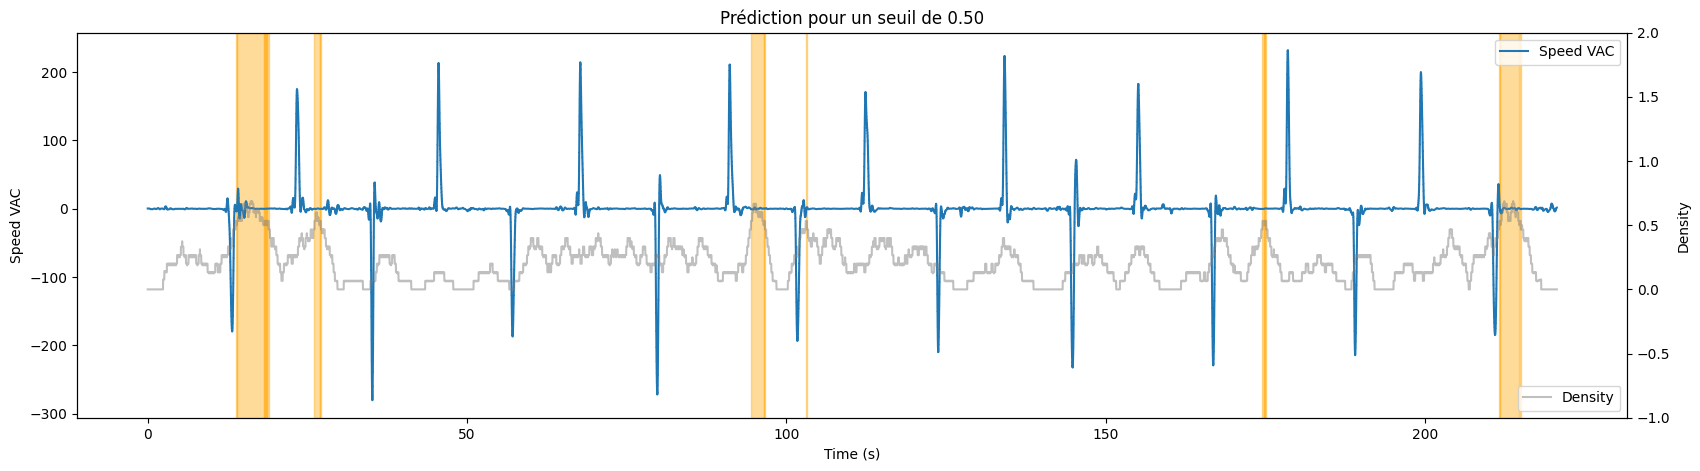

In [8]:
THRESHOLD_DENSITY_PREDICTION = 0.5

movement_times = density_plot(
        raws,
        movement_density,
        threshold=THRESHOLD_DENSITY_PREDICTION,
        plot_density=True,
    )

In [9]:
pd.DataFrame(pipeline['additional_info']['model_performance'], index=[0])

,Score A,Score B,Score C,Score X
0,0.616139,0.625,0.611529,0.603253


In [14]:
NUMBER_OF_SESSIONS

10